In [1]:
import torch
import torch.nn as nn
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.ao.nn.quantized.functional import conv2d
from torch.multiprocessing import start_processes
from torch.utils.data import Dataset, DataLoader


def process(df,TARGET_COL,LOOKBACK,BATCH_SIZE,HIDDEN_SIZE,CONV1_SIZE,NUM_LAYERS,OUTPUT_SIZE,EPOCHES,target_value):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #df['RSI'] = ta.momentum.RSIIndicator(df['close'],window=50,fillna=False).rsi()
    #df['kama'] = ta.momentum.kama(df['close'],window=14,fillna=False)
    #df['adx'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],window=14,fillna=False).adx()
    #df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['tick_volume']).on_balance_volume()
    #df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['high'],low=df['low'],close=df['close'],volume=df['tick_volume'],window=20).chaikin_money_flow()
    #boll = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    #df['BB_High'] = boll.bollinger_hband()
    #df['BB_Low'] = boll.bollinger_lband()
    #df['BB_Mid'] = boll.bollinger_mavg()
    #df['EMA_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator()
    #df['EMA_50'] = ta.trend.EMAIndicator(close=df['close'], window=50).ema_indicator()
    df['LOG'] = np.log(df['close'] / df['close'].shift(1))
    df['PCTC'] = df['close'].pct_change()
    df['HLD'] = df['high'] - df['low']
    df['OCD'] = df['close'] - df['open']

    df = df.bfill()

    features = df.columns.tolist()

    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)


    print(df)
    def create_dataset(data):
        X,y = [],[]
        for i in range(len(data) - LOOKBACK - 1):
            X.append(data[i:(i + LOOKBACK), :])  # Take all columns
            y.append(data[i + LOOKBACK, TARGET_COL])

        return np.array(X), np.array(y)

    X,y = create_dataset(scaled_df)

    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)  # shuffle=False for time series
    y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)  # shuffle=False for time series

    X_train = torch.tensor(X_train).to(device)
    y_train = torch.tensor(y_train).to(device)
    X_test = torch.tensor(X_test).to(device)
    y_test = torch.tensor(y_test).to(device)

    class StockDataset(Dataset):
        def __init__(self, features, targets):
            self.features = features
            self.targets = targets

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return self.features[idx], self.targets[idx]

    train_dataset = StockDataset(X_train, y_train)
    test_dataset = StockDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size,conv_channels, output_size, num_layers, dropout = 0.0, kernel_size = 3):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers

            # CNN layer for feature extraction
            self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1)

            # LSTM layer for temporal modeling
            self.lstm = nn.LSTM(32, hidden_size, num_layers, batch_first=True)

            # Fully connected layer for output
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            # Apply CNN to the input (batch_size, sequence_length, features)
            x = x.permute(0, 2, 1) # Reshape for Conv1d
            x = self.conv1d(x)
            x = x.permute(0, 2, 1) # Reshape back for LSTM

            # Pass through LSTM
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))

            # Take the output from the last time step and pass to the linear layer
            out = self.fc(out[:, -1, :])
            return out

    num_features = scaled_df.shape[1]
    model = LSTM(input_size=num_features, hidden_size=HIDDEN_SIZE, conv_channels=CONV1_SIZE,output_size=OUTPUT_SIZE,num_layers=NUM_LAYERS).to(device)
    from torch import optim

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(x_batch.float())
            loss = criterion(y_pred.flatten(), y_batch.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.5f}")

    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch.float())
            predictions.extend(y_pred.flatten().cpu().numpy())
            actuals.extend(y_batch.flatten().cpu().numpy())
            loss = criterion(y_pred.flatten(), y_batch.float())
            running_loss += loss.item()

        avg_loss = running_loss / len(test_loader)
        print(f"Loss: {avg_loss:.5f}")
        predictions = np.array(predictions)

    actuals = np.array(actuals)

    def inverse_close(scaled_close):
        dummy = np.zeros((scaled_close.shape[0], len(features)))
        dummy[:, 3] = scaled_close
        return scaler.inverse_transform(dummy)[:, 3]

    actual_prices = inverse_close(actuals.flatten())
    pred_prices_test = inverse_close(predictions.flatten())


    # Plot predictions vs real values
    plt.figure(figsize=(10,5))
    plt.plot(pred_prices_test[-10:], label="Real")
    plt.plot(actual_prices[-10:], label="Predicted")
    plt.legend()
    plt.title("Test Results: Real vs Predicted")
    plt.show()
    last_seq = scaled_df[-LOOKBACK:]
    input_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)

    print(last_seq.shape)
    model.eval()

    with torch.no_grad():
        next_scaled = model(input_seq.float())
        next_scaled = next_scaled.item()

    dummy = np.zeros((1, scaled_df.shape[1]))
    dummy[0, TARGET_COL] = next_scaled  # put predicted scaled value in target column
    next_pred = scaler.inverse_transform(dummy)[0, TARGET_COL]

    print("Last Close", df.iloc[-1, TARGET_COL])
    print("Next predicted value:", next_pred)
    print("Next real value:", target_value)
    print("Risidual:", next_pred - target_value)
    data = {
        'last_close': df.iloc[-1, TARGET_COL],
        'predict':next_pred,
        'target_value':target_value,
        'residual': next_pred-target_value,
        'LOOKBACK':LOOKBACK,
    }
    return data




HIDDEN_SIZE: 99999
(99999, 9)
1.15965
          open     high      low    close  tick_volume  spread  real_volume  \
0      1.39558  1.39724  1.39470  1.39523         3353      20            0   
1      1.39526  1.39585  1.39337  1.39475         2197      20            0   
2      1.39473  1.39563  1.39455  1.39478         2148      20            0   
3      1.39476  1.39518  1.39347  1.39353          929      20            0   
4      1.39461  1.39683  1.39460  1.39660          723      20            0   
...        ...      ...      ...      ...          ...     ...          ...   
99993  1.16072  1.16134  1.16042  1.16080         1864      15            0   
99994  1.16079  1.16082  1.15880  1.15889         2299      15            0   
99995  1.15891  1.15932  1.15821  1.15835         1895      15            0   
99996  1.15837  1.15882  1.15825  1.15859         1742      15            0   
99997  1.15859  1.15943  1.15826  1.15878         3207      15            0   

            L

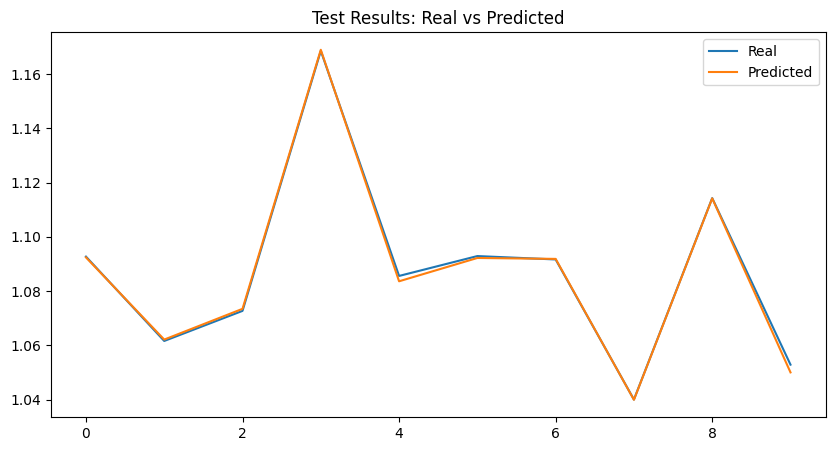

(120, 11)
Last Close 1.15878
Next predicted value: 1.1587759223683582
Next real value: 1.15965
Risidual: -0.0008740776316418231


In [2]:
TARGET_COL = 3
LOOKBACK = 120
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
HIDDEN_SIZE = 1024
CONV1_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
EPOCHS = 30

data = pd.DataFrame(columns=["last_close", "predict", "residual", "LOOKBACK"])
data.to_csv("result.csv", index=False)

numbers = [99999]

for SIZE in numbers:
    print(f"HIDDEN_SIZE: {SIZE}")
    df = pd.read_csv("EURH1.csv")
    df = df.tail(SIZE)
    print(df.shape)
    target_value = df.iloc[-1, 5]
    print(target_value)
    df = df.iloc[:len(df)-1, 2:]
    new_data = process(df,TARGET_COL,LOOKBACK,BATCH_SIZE,HIDDEN_SIZE,CONV1_SIZE,NUM_LAYERS,OUTPUT_SIZE,EPOCHS,target_value)
    data = pd.DataFrame([new_data])
    data.to_csv("result.csv", index=False,mode='a')